In [1]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy import stats

batch1 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch2.pkl','rb'))
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

numBat2 = len(batch2.keys())

batch3 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}

In [17]:
sort=[]
for i in bat_dict.keys():
    a=len(bat_dict[i]['summary']['cycle'])+1
    sort.append([a,i])
    
# 색 조절.
sort=sorted(sort)
sort=np.array(sort)# cycle 순으로 정리 
sortcycle=sort[:,0].astype(float)
color=sortcycle/np.max(sortcycle)
chargecolor=cm.coolwarm(color)

In [18]:
print(len(batch1.keys()))
print(len(batch2.keys()))
print(len(batch3.keys()))

41
43
40


[-5.01486104 -5.01395962 -4.73699974 -4.44261336 -4.64774366 -4.17887796
 -3.7688779  -3.81348608 -4.05938368 -4.14689653 -4.04606984 -4.0179491
 -4.09941368 -3.97015945 -3.65008055 -3.61990683 -3.36723741 -3.35033805
 -4.04079364 -3.93866252 -4.02788882 -3.79522    -3.8537032  -3.84471181
 -3.8382817  -3.74469922 -3.77773262 -3.6464635  -3.6670576  -3.84861616
 -3.77260582 -3.66950134 -3.67393889 -3.43304817 -3.50453372 -4.05521271
 -4.07151397 -3.66585579 -3.66777907 -3.4207     -3.42529224] [3.26764098 3.33445375 3.34966598 3.15654915 3.23274206 3.03100428
 2.80345712 2.93951925 3.02284061 2.89652622 2.94448267 2.85672889
 2.93550727 2.93298082 2.83947805 2.89652622 2.72754126 2.74741181
 3.00603795 3.00732095 2.93145787 2.93951925 2.92531209 2.93449845
 2.96236934 2.85064624 2.94250411 2.86391738 2.87909588 2.87040391
 2.84695533 2.84757266 2.81157501 2.79028516 2.79588002 2.98497713
 3.02160272 2.84633711 2.81358099 2.78958071 2.77742682]


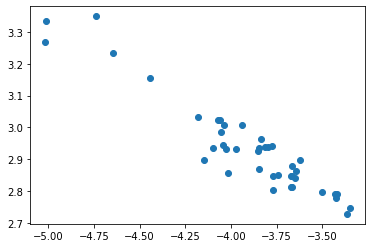

In [19]:
from sklearn.linear_model import ElasticNetCV
regr=ElasticNetCV(cv=4)
Cycle=[]
VAR=[]
for i,j in enumerate(batch1.keys()):
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=Qdlin100-Qdlin10
    var,cycle=np.var(diff),len(bat_dict[j]['summary']['cycle'])+1
    VAR.append(var)
    Cycle.append(cycle)
x_val=np.array(VAR)
y_val=np.array(Cycle)
X_val=np.log10(x_val)
Y_val=np.log10(y_val)
print(X_val,Y_val)
plt.scatter(X_val,Y_val)

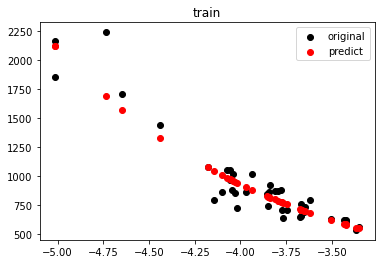

In [20]:
X=X_val.reshape(-1,1)
X.shape, Y_val.shape
regr.fit(X,Y_val)
regr.alpha_
regr.coef_
regr.intercept_
y_pred1=regr.predict(X)
plt.scatter(X,10**Y_val,color='black',label='original')
plt.scatter(X,10**y_pred1,color='red',label='predict')
plt.title('train')
plt.legend()

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
rmse1=np.sqrt(mean_squared_error(10**Y_val,10**y_pred1))
print('train Mean Percent Error, RMSE')
mean_absolute_error(Y_val,y_pred1)*100,rmse1

train Mean Percent Error, RMSE


(3.739904358134776, 128.9470433403474)

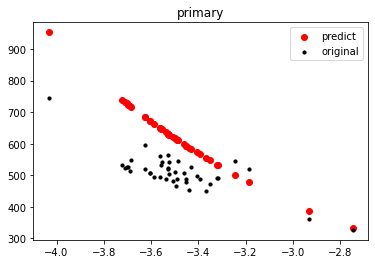

In [22]:
Cycle2=[]
VAR2=[]
for i,j in enumerate(batch2.keys()):
    if j=='b2c1':
        continue
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=Qdlin100-Qdlin10
    var,cycle=np.var(diff),len(bat_dict[j]['summary']['cycle'])+1
    VAR2.append(var)
    Cycle2.append(cycle)
x_val2=np.array(VAR2)
y_val2=np.array(Cycle2)
X_val2=np.log10(x_val2)
Y_val2=np.log10(y_val2)
X2=X_val2.reshape(-1,1)

X2.shape, Y_val2.shape
y_pred=regr.predict(X2)
plt.scatter(X2,10**y_pred,color='r',label='predict')
plt.scatter(X_val2,10**Y_val2,color='black',s=10,label='original')
plt.title('primary')
plt.legend()

In [23]:
print('primary Mean Percent Error, RMSE')
rmse=np.sqrt(mean_squared_error(10**Y_val2,10**y_pred))
mean_absolute_error(Y_val2,y_pred)*100,rmse

primary Mean Percent Error, RMSE


(8.701777304915481, 128.09539224879768)

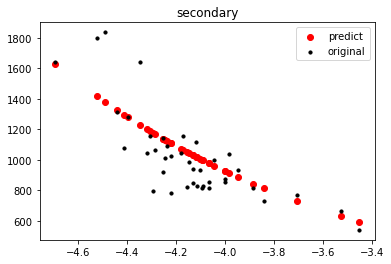

In [24]:
# fig2 Q100_Q10 는 4개의 cell을 제거 했지만 여기는 그대로 계산.
Cycle3=[]
VAR3=[]
for i,j in enumerate(batch3.keys()):
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=Qdlin100-Qdlin10
    var,cycle=np.var(diff),len(bat_dict[j]['summary']['cycle'])+1
    VAR3.append(var)
    Cycle3.append(cycle)
x_val3=np.array(VAR3)
y_val3=np.array(Cycle3)
X_val3=np.log10(x_val3)
Y_val3=np.log10(y_val3)
X3=X_val3.reshape(-1,1)

X3.shape, Y_val3.shape
y_pred3=regr.predict(X3)
plt.scatter(X3,10**y_pred3,color='r',label='predict')
plt.scatter(X_val3,10**Y_val3,color='black',s=10,label='original')
plt.title('secondary')
plt.legend()

In [25]:
print('secondary Mean Percent Error, RMSE')
rmse3=np.sqrt(mean_squared_error(10**Y_val3,10**y_pred3))
mean_absolute_error(Y_val3,y_pred3)*100,rmse3

secondary Mean Percent Error, RMSE


(5.320859879268971, 175.2794155755679)

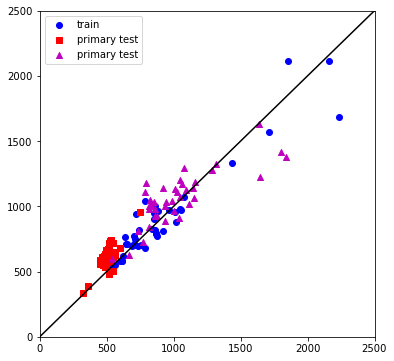

In [26]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**Y_val,10**y_pred1,color='b',marker='o',label='train')
plt.scatter(10**Y_val2,10**y_pred,color='r',marker='s',label='primary test')
plt.scatter(10**Y_val3,10**y_pred3,color='m',marker='^',label='primary test')
plt.axis([0,2500,0,2500])
plt.legend()